In [1]:

#package imports
# UTILS
import datetime as dt
from datetime import datetime,time,timedelta
import os
## PLOT
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.dates import DateFormatter
## MATH

import numpy as np



## ASTROPY
from astropy.io import fits
from astropy.time.core import Time, TimeDelta
from astropy.table import Table
import astropy.units as u

import ancillary_functions as af

# File import

In [2]:
#files to be used
# SCI file - L4 spectrogram - STIX
sci_file = "data/solo_L1_stix-sci-xray-spec_20220830T020459-20220830T081003_V02_2208301654-61465.fits"


### The header
With the ancillary processes unified in functions, display the observation conditions easily

In [3]:
print("\nSCI information:")
hdulist = fits.open(sci_file)
header = hdulist[0].header
af.print_obs_info(header)



SCI information:
Observatory: Solar Orbiter
Instrument: STIX
Observation time:
 from: 2022-08-30T02:04:59.812
 to: 2022-08-30T08:10:03.650
Distance s/c - sun: 0.764934298901394 AU
Time delay s/c - sun: 381.705874472152 s


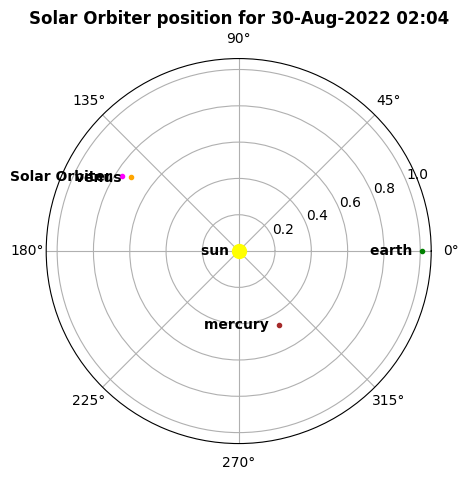

In [4]:
af.plot_sc_position(header)

### The Data
The information in the FITS files is in labeled data structures that contain the science data, associated errors, information about the data compression process and instrument control data as well. 

In [5]:
hdulist[0].data 
#index 0 has no data associated

In [6]:
hdulist[1].data.columns
# auxiliary data on compression

ColDefs(
    name = 'tc_packet_id_ref'; format = 'I'; bscale = 1; bzero = 32768
    name = 'tc_packet_seq_control'; format = 'I'; bscale = 1; bzero = 32768
    name = 'request_id'; format = 'J'; bscale = 1; bzero = 2147483648
    name = 'num_substructures'; format = '98I'; bscale = 1; bzero = 32768; dim = '(98)'
    name = 'index'; format = 'B'
    name = 'packet'; format = '98I'; bscale = 1; bzero = 32768; dim = '(98)'
    name = 'raw_file'; format = '98A'; dim = '(98,1)'
    name = 'parent'; format = '74A'
    name = 'compression_scheme_counts_skm'; format = '3B'; dim = '(3)'
    name = 'compression_scheme_triggers_skm'; format = '3B'; dim = '(3)'
    name = 'detector_masks'; format = '32B'; dim = '(32)'
    name = 'energy_bin_edge_mask'; format = '33B'; dim = '(33)'
    name = 'time_stamp'; format = 'D'; unit = 's'
)

In [7]:
hdulist[2].data.columns
#TIME BINS, TIME BIN LENGTHS, detector triggers, COUNTS

ColDefs(
    name = 'time'; format = 'J'; unit = 'cs'; bscale = 1; bzero = 2147483648
    name = 'timedel'; format = 'J'; unit = 'cs'; bscale = 1; bzero = 2147483648
    name = 'triggers'; format = 'J'; bscale = 1; bzero = 2147483648
    name = 'triggers_comp_err'; format = 'E'
    name = 'rcr'; format = 'B'
    name = 'pixel_masks'; format = '12B'; dim = '(12)'
    name = 'counts'; format = '32I'; unit = 'count'; bscale = 1; bzero = 32768; dim = '(32)'
    name = 'counts_comp_err'; format = '32E'; unit = 'count'; dim = '(32)'
    name = 'control_index'; format = 'B'
)

**Note:** be careful with the units! they're specified in the fits header. for instance, the units of time are not seconds ('s') but rather centiseconds ('cs') which is not intuitive. all information you might need is in the header.

In [8]:
hdulist[4].data.columns
#Energy channel number,with low and high boundaries for energy bins (in kev)

ColDefs(
    name = 'channel'; format = 'B'
    name = 'e_low'; format = 'E'; unit = 'keV'
    name = 'e_high'; format = 'E'; unit = 'keV'
)

# Data structures

### Time and energy bins
From observing the column names we can see that frame 4 contains the information about the energy. It contains data about the energy channels of the instrument organized in a structure we can associate with the data of the measurements.

In [9]:
# Table are useful to organize the information available in fits files
energies = Table(hdulist[4].data)
energies

channel,e_low,e_high
uint8,float32,float32
0,0.0,4.0
1,4.0,5.0
2,5.0,6.0
3,6.0,7.0
4,7.0,8.0
5,8.0,9.0
...,...,...
25,63.0,70.0
26,70.0,76.0


In [10]:
n_energies=len(energies)
print(n_energies,"energy channels")

32 energy channels


The second frame is the one containing the information about the time axis (time bins and the length of each time bin) the counts and count errors. As the measurements are detector counts per energy bin per time bin, **we expect the counts to be a multidimensional array (2D)** with the same number of columns and rows as the number of time bins and energy bins. 

In [11]:
# in this table we have the time, time bin length(timedel), counts anc count errors
data = Table(hdulist[2].data)
data

time,timedel,triggers,triggers_comp_err,rcr,pixel_masks,counts,counts_comp_err,control_index
uint32,uint32,uint32,float32,uint8,uint8[12],uint16[32],float32[32],uint8
25,50,31743,591.2068,0,1 .. 1,607 .. 30,18.47972 .. 0.70710677,0
75,50,31743,591.2068,0,1 .. 1,543 .. 37,18.47972 .. 1.2247449,0
125,50,31743,591.2068,0,1 .. 1,543 .. 24,18.47972 .. 0.70710677,0
175,50,31743,591.2068,0,1 .. 1,607 .. 33,18.47972 .. 1.2247449,0
225,50,31743,591.2068,0,1 .. 1,543 .. 20,18.47972 .. 0.70710677,0
275,50,31743,591.2068,0,1 .. 1,543 .. 30,18.47972 .. 0.70710677,0
...,...,...,...,...,...,...,...,...
2186875,790,8703,295.6036,0,1 .. 1,135 .. 543,4.6368093 .. 18.47972,0
2187295,50,495,9.246621,0,1 .. 1,5 .. 30,0.0 .. 0.70710677,0


In [12]:
# since the time is given in seconds after the observation begins( at t_O),
# the time axis is t = t0 + Dt(s) 
#time units in cs ! 
data_time = Time(header['date-obs']) + TimeDelta(data['time'] * u.cs)

### Counts vs. counts/sec

In [13]:
# time bins length timedel (i.e. the interval of time in which the counts were detected)
# is not constant, is wiser to compare cts/sec instead of counts
timedelta_sec = data["timedel"]/100
data["cts_per_sec"]=data["counts"]/(timedelta_sec).reshape(-1,1)
# in this process we're just divding the counts in each time bin by the vector containing the time bin lengths
# resulting in the count rate per time bin (counts/second)


# Quicklook and low latency data

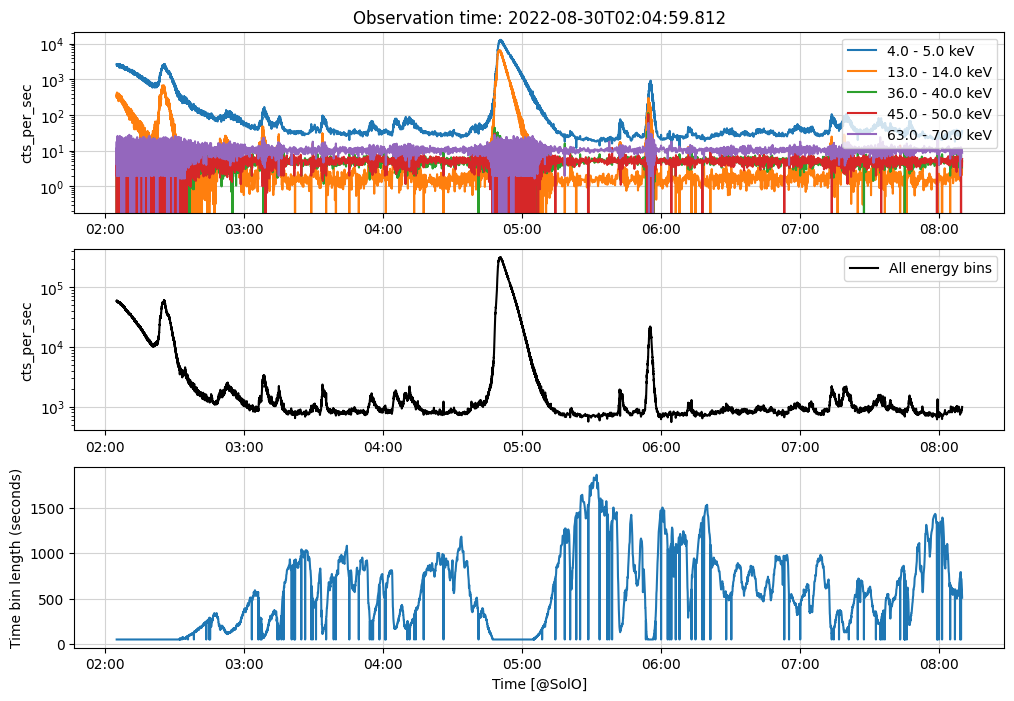

In [14]:
# energy channels to plot
_plot_channels=[1,10,20,22,25]

# use the cts_col parameter to plot the counts ("counts") or the counts/sec ("cts_per_sec")
cts_col="cts_per_sec"
# ACTIVITY - check both, counts and counts/sec and compare the effects of
# a non-contants time bin length



# PLOT
plt.figure(figsize=(12,8))

# paint cts/sec for each seleceted channel

ax=plt.subplot(311)
for i in _plot_channels:
     # energy bin boundaries
    _energy_lbl = f"{energies['e_low'][i]} - {energies['e_high'][i]} keV"
    # plot counts corresponding to channel i
    ax.plot(data_time.datetime,data[cts_col][:,i],label=_energy_lbl)

# format the date axis (%H: hour,%M: minute,%H: second)
# you might use your prefered format
myFmt = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)
# add elegend, plot in logscale,do title
ax.legend()
ax.set_yscale("log")
ax.set_ylabel(cts_col)
ax.set_title("Observation time: "+header["date-obs"])
ax.grid(color='lightgrey')
#paint all counts
ax2=plt.subplot(312)

# add the cts of all channels
summed_data = np.sum(data[cts_col],axis=1)

ax2.plot(data_time.datetime,summed_data,label="All energy bins",c="k")
# fortmat date
myFmt = DateFormatter("%H:%M")
ax2.xaxis.set_major_formatter(myFmt)

ax2.legend()
ax2.set_yscale("log")
ax2.set_ylabel(cts_col)
ax2.grid(color='lightgrey')


#paint variation of time bin lengths 
ax3=plt.subplot(313)

ax3.plot(data_time.datetime,data["timedel"])
# fortmat date
myFmt = DateFormatter("%H:%M")
ax3.xaxis.set_major_formatter(myFmt)

ax3.set_xlabel("Time [@SolO]")
ax3.set_ylabel("Time bin length (seconds)")
ax3.grid(color='lightgrey')

### Remark:


note that for some files, the high energy channels above certain limit have no counts (counts/sec=0), so they will not appear in the log-plot at the top  (cts/sec per energy channel). 

This suggests that the information in the file is "incomplete" some of the counts are missing. In fact, this is done to optimize the telemetry between the solar orbiter and the Earth: if the flare has no counts in the high-energy channels, let's say above 50 keV, then only the data from the channels with flare-induced counts is sent back to Earth. Summarizing, **if the counts above 50 keV are not affected by the flare event, then these channels are cropped out to optimize the telemetry rate with solar Orbiter**. 

**Activity -** Play with the "_plot_channels" parameter (list of channel numbers) to see if all energy channels are available, and if not, set the energy threshold below which the channels with information are. **It's important to define this energy range in order to continue with further analysis.** 

### Energy bin integration 
The measured X-ray radiation can come from two main sources: from **flare-heated plasma** (**thermal component**, Usually at low energies below ~10 or ~20 kev) and from the a**ccelerated non-thermal electrons** losing its energy through bremssttrahlung when falling down to the photosphere (**non-thrermal component**. Higher energy ranges, usually above ~15 or ~20 kev). 
The observed counts (and corresponding spectra) is the sum of both components; The energy range for which the thermal component is dominant varies from flare to flare (differentiable by spectroscopy), thus plotting the counts quicklook curves by energy ranges (grouping energy bins) comes in handy to **determine the influence of the flare in different energy regimes**.

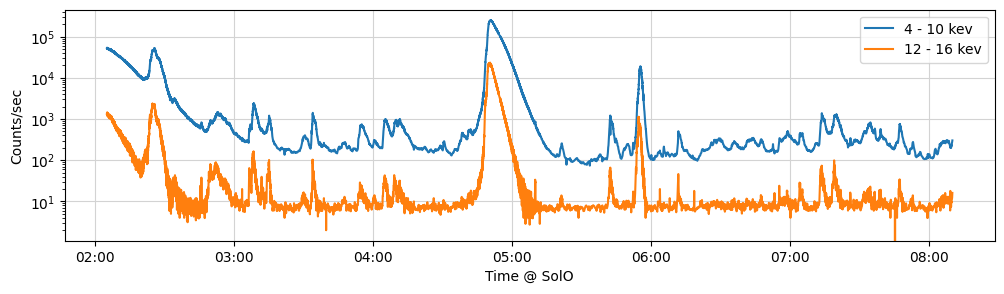

In [15]:
# energy channels to plot
# ACTIVITY once you defined the energy range for which the data is available, define 2 or 3 energy bins to plot
# for the thermal range you can use [4,10]  (4 to 10 keV), the other bins are up to you.
energy_bins=[ [4,10] , [12,16] ]
energy_range = [4,50]

# for each energy range 
ranges_to_plot = []
for er in energy_bins:
    # select the energy bin indexes that fall into the desired energy interval
    ii = np.logical_and(energies["e_low"]>=er[0],energies["e_high"]<=er[1])
    jj= np.where(ii)[0].astype(int)
    
    # select these energies
    selected_eb = energies[jj]
    # from the counts, take only the ones associated wtih the selected energy range
    sel_counts = data["cts_per_sec"][:,jj]
    # add the contribution of the energy bins within the selected energy range
    sel_counts =np.sum(sel_counts,axis=1)
    
    # create a directory with the energy boundaries, associated counts and indexes 
    to_plot = {"e_low":selected_eb[0]["e_low"],
               "e_high":selected_eb[-1]["e_high"],
               "idx":jj,
               "cts_per_sec":sel_counts
              }
    # append this to the "to plot" list
    ranges_to_plot.append(to_plot)
    
    
# PLOT
plt.figure(figsize=(12,3))
ax= plt.subplot(111)
# plot each "to_plot" element
for  tp  in ranges_to_plot:
    ax.plot(data_time.datetime,tp["cts_per_sec"],label=f"{round(tp['e_low'])} - {round(tp['e_high'])} kev")
    
myFmt = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)

plt.yscale("log")
plt.ylabel("Counts/sec")
plt.xlabel("Time @ SolO")
plt.legend()
plt.grid(color='lightgrey')


# spectrogram
plotting all the lightcurves at the same time is convenient to see the magnitude, reach (in energy) and duration of the flare. However, plotting all the curves at the time might not offer the best visualization. Instead, is better to use spectrograms, which represent the count rate with colors in a time-energy grid.  

Text(0.5, 1.0, 'Counts spectrogram')

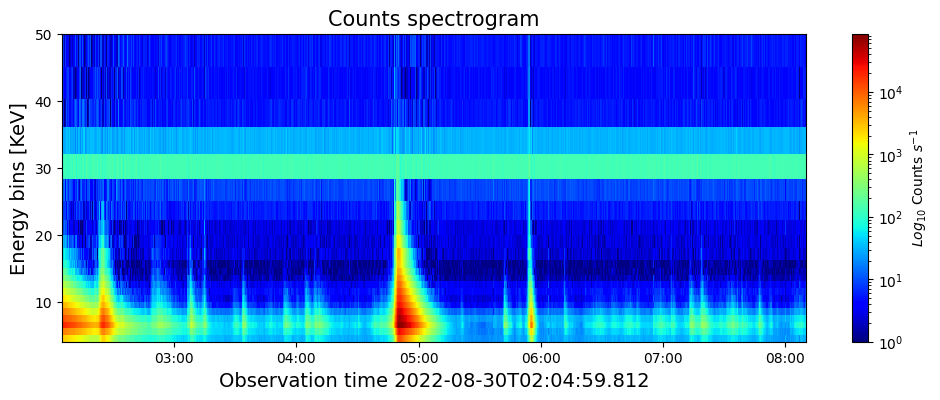

In [16]:
# ACTIVITY using the quicklooks, deduce the energy interval for which this file has counts and define the energy range
# The low range ususally is 4kev, the at high energies are the ones cropped out.
energy_range= [4,50]
plt.figure(figsize=(12,4))
ax = plt.subplot(111)


myFmt = mdates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)

# for plotting, we are using the mean energy of the bin, except for the last bin where the high boundary
# is inifinte, then whe assing the value of the lower boundary of the energy bin
mean_e = np.array([np.mean([e["e_low"],e["e_high"]]) if e["e_high"]!=np.inf else e["e_low"] for e in energies ])



cts_data = np.array(data['cts_per_sec']).T
#to plot we replace empty data and 0 counts with a 1
# do NOT do this for spectroscopy analysis , just for visualization
cts_data=np.nan_to_num(cts_data,nan=1)
cts_data[cts_data<=0]=1

ii = np.logical_and(energies["e_low"]>=energy_range[0],energies["e_high"]<=energy_range[1])
jj= np.where(ii)[0].astype(int)
cts_data = cts_data[jj,:]
mean_e = mean_e[jj]


cm= plt.pcolormesh(data_time.datetime,mean_e,cts_data,shading="auto",cmap="jet",vmin=1,norm="log")


cblabel = "$Log_{10}$ Counts $s^{-1}$" 
plt.colorbar(cm,label=cblabel)

plt.ylim(*energy_range)
plt.xlabel("Observation time "+header["date-obs"],fontsize=14)
plt.ylabel('Energy bins [KeV]',fontsize=14)
plt.title("Counts spectrogram",fontsize=15)


### To Think about...
* What is the relation between the evolution of time bin length and the counts per second (count rate) in the detectors? 
* How do you think making an integration of  all the energy bins  (e.g. low latency data) is useful for the control and data collection of Solar Orbiter and STIX?

* there are two clear tendencies: higher count rates in x-ray during flare events and a **background level**, unrelated to the presence of flares, in which the count rate is rather constant . Why is this background level different for each energy bin? How are these counts affecting the information about the spectrum of the time periods with flares (and the spectrogram in general)?

# Removing the background

The background is taken during a "quiet" time period in which there are no counts associated with solar flares. Its count rate is rather constant and always present. To obtain an accurate energy spectrum of flares, we must first subtract this background counts for each time bin.

**The background count rate is quite stable over long periods of time** with no significant variations over the course of days and even weeks. For this reason, the STIX background measurements are taken once a week (with exceptions), thus **when analyzing STIX data the "bkg file" might not be from the same day of the measurements, but it should be from the closest bkg measurements (before or after the flare)**. 

### The background (BKG) file

In [22]:
# background L1 file
bkg_file = "data/solo_L1_stix-sci-xray-cpd_20220911T021423-20220911T030223_V02_2209115148-62679.fits"

BKG information:
Observatory: Solar Orbiter
Instrument: STIX
Observation time:
 from: 2022-09-11T02:14:23.017
 to: 2022-09-11T03:02:23.022
Distance s/c - sun: 0.6452445535300616 AU
Time delay s/c - sun: 321.9801189557256 s


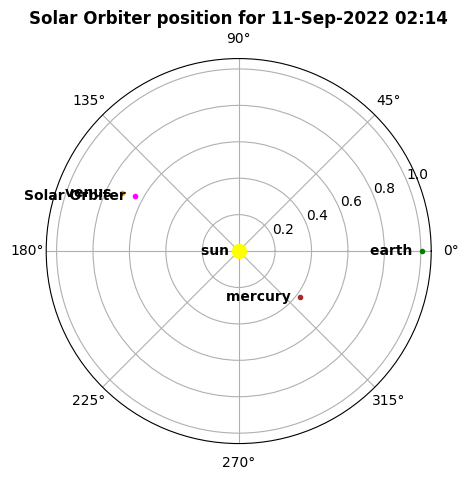

In [23]:
# information on the BKG file
print("BKG information:")
hdulist_bkg = fits.open(bkg_file)
header_bkg = hdulist_bkg[0].header
af.print_obs_info(header_bkg)
af.plot_sc_position(header_bkg)

**Compare** the observation date and the relative position between the science file and the background file. Is the difference in position signifficant? Is the difference in observation time large (+ 20 days)?  

### Background counts

In [24]:
# file data
data_bkg = Table(hdulist_bkg[2].data)

# energies and mean energy for  BKG file
energies_bkg = Table(hdulist_bkg[4].data)
n_energies_bkg = len(energies_bkg)

print("energy channels in BKG : ",n_energies_bkg)



energy channels in BKG :  31


we compare the energy bins of the science file and the ones we just extracted from the bkg file. Ideally we have bkg measurements for all energy bins, but when is not possible we might need to take this into account for properly subtract the background in the next steps. 

In [25]:
energies_bkg

channel,e_low,e_high
uint8,float32,float32
0,4.0,5.0
1,5.0,6.0
2,6.0,7.0
3,7.0,8.0
4,8.0,9.0
5,9.0,10.0
...,...,...
24,63.0,70.0
25,70.0,76.0


In [26]:
energies

channel,e_low,e_high
uint8,float32,float32
0,0.0,4.0
1,4.0,5.0
2,5.0,6.0
3,6.0,7.0
4,7.0,8.0
5,8.0,9.0
...,...,...
25,63.0,70.0
26,70.0,76.0


**Question**: are the energy bin arrays the same? what's different?

for now let's estimate the backgrounnd count rate, we need to consider the time unis as we are using the count rate  in units of counts/second. 

In [27]:
# wee look for the units of time and time delta
print(hdulist_bkg[2].header['ttype1'],hdulist_bkg[2].header['tunit1'])
print(hdulist_bkg[2].header['ttype2'],hdulist_bkg[2].header['tunit2'])

time cs
timedel cs


In [28]:
# the bakground counts have a weird shape, we need to sum up the counts among 2 axes to obtain 
# the counts correpsonding to each energy channel

# creating count rate
cts_ = np.sum(data_bkg["counts"],axis=(1,2))
timedel = data_bkg['timedel']/100 # data in cs, convert timedel to seconds 
data_bkg["cts_per_sec"] = [(cts_/timedel)[0].reshape(n_energies_bkg)] # count rate in cts per sec

### Background spectrum

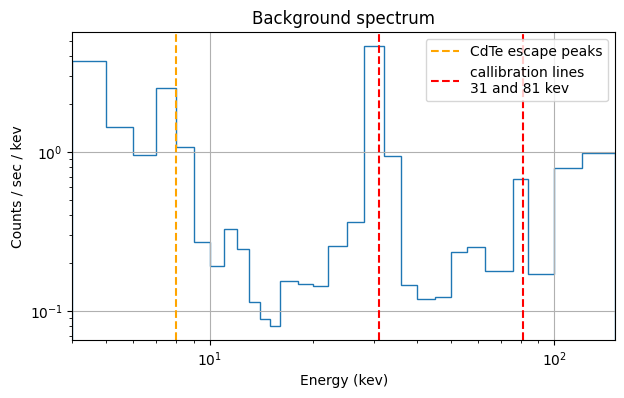

In [29]:
# as last energy bin top boundary is 'infinite' we replace it by 200 for plotting
energy_edges =  energies_bkg["e_low"].tolist() + [200]
mean_e_bkg = np.array([np.mean([e["e_low"],e["e_high"]]) if e["e_high"]!=np.inf else e["e_low"] for e in energies_bkg ])

plt.figure(figsize=(7,4))
plt.stairs(data_bkg["cts_per_sec"][0]/mean_e_bkg,energy_edges)
plt.axvline(8,c="orange",ls="--",label="CdTe escape peaks")
plt.axvline(31,c="r",ls="--",label="callibration lines\n31 and 81 kev")
plt.axvline(81,c="r",ls="--")
plt.xlabel("Energy (kev)")
plt.ylabel("Counts / sec / kev")
plt.title("Background spectrum")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlim(4,150)
plt.grid()

the **background x-ray spectrum** shows enhanced emission for certain energies (peaks). **The peaks at 81 kev and 31 kev due to the radiactive source inside the instrument**, these spectral lines are used for callibration.

Are these callibration peaks in the expected position? are all the peaks visible the bkg spectrum also visible in the spectrogram you made before?

### remove the bkg counts

In order to subtract properly the energy bins for which the background measurements are available we have to make the background spectrum countrate (for 31 energies) into an array of the same length as the measured spectra for each timestep (32 energies). With this code snippet below we search in the bkg energies for coincidences with the energy bins of the science file. For the bins without information (in this case the bin from 0 to 4 keV) we use a bkg countrate of 0 . 

In [30]:

#we'll store here the 32 bkg count rates for each energy bin 
bkg_countrate= []

# we iterate over the energy bins of the science file 
for e in energies:
    # we look for bins with the same bounds
    bkg_energy_bin = energies_bkg[energies_bkg[["e_low","e_high"]]==e[["e_low","e_high"]]]
    # if found, use the count rate value for that energy bin that we already estimated
    # if not, use 0 instead
    if len(bkg_energy_bin)==1:
        bkg_countrate.append(data_bkg["cts_per_sec"][0][bkg_energy_bin["channel"]][0])
    else:     
        bkg_countrate.append(0)

In [31]:
# reshape the bkg spectrum (vector of len n_energies) into a 2D array of the same shape as the science cts/sec  
# in order to remove the bkg counts per energy bin from every time bin in the sci file 

# repet the cts/sec for each time bin to make a counts "matrix" for 
# the bkg in the same shape as cts/sec for SCI file
bkg_array = np.repeat(np.array([bkg_countrate])[None, :], len(data["time"]), axis=1)
# subtract and limit lower boundary to 0
corr_array =data["cts_per_sec"]-bkg_array
corr_array = np.clip(corr_array,0,np.inf)
corr_array = corr_array.reshape( ( len(data["time"]) , n_energies ) )

# save BKG and corrected cts/Sec
data["bkg_cts_per_sec"] =data_bkg["cts_per_sec"]
data["corrected_cts_per_sec"] = corr_array

Text(0.5, 1.0, 'Background-subtracted counts spectrogram')

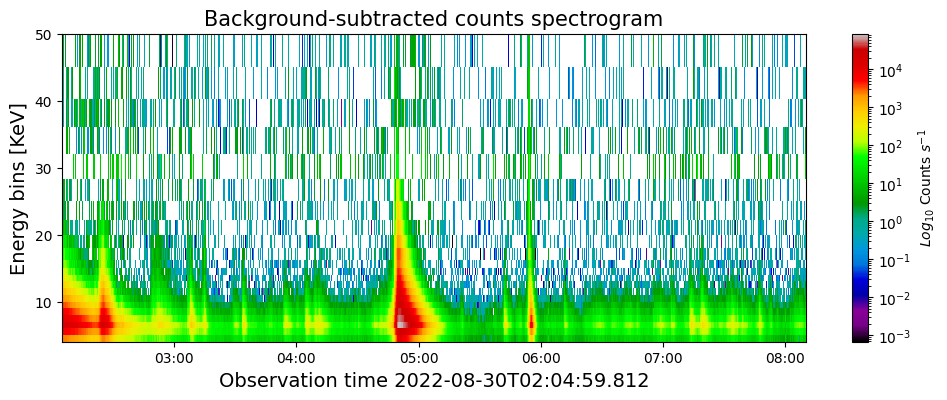

In [32]:
# energy range to plot
energy_range= [4,50]

# PLOT
plt.figure(figsize=(12,4))
ax = plt.subplot(111)

# date formatting
myFmt = mdates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)

# mean energy per bin
mean_e = np.array([np.mean([e["e_low"],e["e_high"]]) if e["e_high"]!=np.inf else e["e_low"] for e in energies ])



#to plot we replace empty data with a 0
# do NOT do this for spectroscopy analysis , just for vnp.insert(X, 0, 6., axis=0)isualization
cts_data = data["corrected_cts_per_sec"].T
cts_data=np.nan_to_num(cts_data,nan=0)

# select only the energies within the energy range to plot
ii = np.logical_and(energies["e_low"]>=energy_range[0],energies["e_high"]<=energy_range[1])
jj= np.where(ii)[0].astype(int)
cts_data = cts_data[jj,:]
mean_e = mean_e[jj]

# plot colormesh
cm= plt.pcolormesh(data_time.datetime,mean_e,cts_data,shading="auto",cmap="nipy_spectral",norm="log")
cblabel = "$Log_{10}$ Counts $s^{-1}$" 
plt.colorbar(cm,label=cblabel)

# scale and labels
plt.ylim(*energy_range)
plt.xlabel("Observation time "+header["date-obs"],fontsize=14)
plt.ylabel('Energy bins [KeV]',fontsize=14)
plt.title("Background-subtracted counts spectrogram",fontsize=15)


The white spaces that may appear in the spectrogram are time bins for which that specific energy bin has 0 counts/sec or less(meaning that the counts were not above the background level). **Without the background, the counts associated with the flare can be better seen** and some features may appear more visible without the influence of background counts. Now that the background has been removed from the data we are ready to do spectroscopy. 